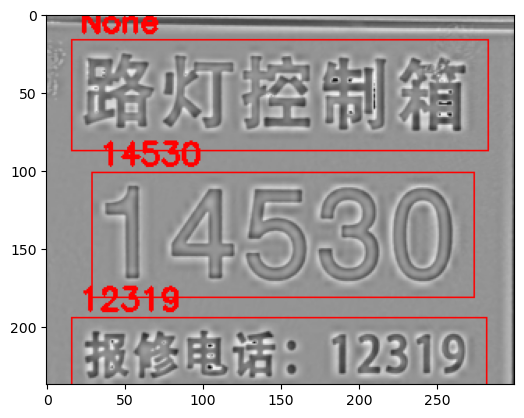

Number #: 1231914530


In [12]:
from imutils import contours
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import myutils

# 绘图展示
def show(img):
    if img.ndim == 2:
        plt.imshow(img, cmap = 'gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def cv_show(name,img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 对图像进行透视变换
src1 = np.array([
    [170,670],
    [975,440],
    [350,1280],
    [1125,1088]
],dtype = np.float32)

dst = np.array([
    [170,640],
    [1100,640],
    [170,1370],
    [1100,1370]
],dtype = np.float32)

src2 = np.array([
    [180,540],
    [1130,530],
    [190,1310],
    [1125,1300]
],dtype = np.float32)

src3 = np.array([
    [425,390],
    [1190,900],
    [65,990],
    [780,1450]
],dtype = np.float32)


#  !!请在这里修改图像路径!! 可以使用的图片的路径为'img/4-1.jpg'  'img/4-2.jpg'   'img/4-3.jpg' 
path = 'img/4-1.jpg'
img_org = cv2.imread(path)

if(path == 'img/4-1.jpg'):
    M = cv2.getPerspectiveTransform(src1, dst)
elif(path == 'img/4-2.jpg'):
    M = cv2.getPerspectiveTransform(src2, dst)
elif(path == 'img/4-3.jpg'):
    M = cv2.getPerspectiveTransform(src3, dst)
else:
    raise "输入的图片有错"   
    
h, w, c = img_org.shape
img_per = cv2.warpPerspective(img_org, M, (w, h))
blockSize = 16
image = myutils.unevenLightCompensate(img_per, blockSize)
per1 = myutils.resize(img_per, width=300)
org = myutils.resize(img_org, width=300)
imag = myutils.resize(image, width=300)
cv_show("imgs",np.hstack([org,per1,imag]))

img_per = img_per[630:1350, 190:1100]
per2 = myutils.resize(img_per, width=300)
image = myutils.unevenLightCompensate(img_per, blockSize)
cv_show('',per2)
# 读取一个模板图像
img = cv2.imread('img/0.jpg')
# 灰度图
ref = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 二值图像
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]

# 计算轮廓
# cv2.findContours()函数接受的参数为二值图，即黑白的（不是灰度图）,cv2.RETR_EXTERNAL只检测外轮廓，cv2.CHAIN_APPROX_SIMPLE只保留终点坐标
# 返回的list中每个元素都是图像中的一个轮廓
 
refCnts, hierarchy = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
cv2.drawContours(img, refCnts, -1, (0, 0, 255), 3)
# 排序，从左到右，从上到下
refCnts = myutils.sort_contours(refCnts, method="left-to-right")[0]  

digits = {}
# 遍历每一个轮廓
for (i, c) in enumerate(refCnts):
    # 计算外接矩形并且resize成合适大小
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
 
    # 每一个数字对应每一个模板
    digits[i] = roi
cv_show('',img)

## 对阴影处理后的图像进行处理寻找有字符的轮廓

# 初始化卷积核
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 12))

# 读取输入图像，预处理
image = myutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 礼帽操作，突出更明亮的区域
# tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1) # ksize=-1相当于用3*3的
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
# 通过闭操作（先膨胀，再腐蚀）将数字连在一起
gradX = cv2.dilate(gradX, sqKernel) # 膨胀
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)

# THRESH_OTSU会自动寻找合适的阈值，适合双峰，需把阈值参数设置为0
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# 再来一个闭操作
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
# 计算轮廓
threshCnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_SIMPLE)
cnts = threshCnts
cur_img = image.copy()
cv2.drawContours(cur_img, cnts, -1, (0, 0, 255), 3)
locs = []
cv_show('gradX',np.hstack([gradX,thresh]))
cv_show('cur_img',cur_img)

# 遍历轮廓
for (i, c) in enumerate(cnts):
    # 计算矩形
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if (w > 15) and (h > 10 and h < 100):
        # 符合的留下来
        locs.append((x, y, w, h))

# 使用阴影处理后的图像进行模板匹配效果不好，故使用原图来进行模板匹配的操作
img_gray = cv2.cvtColor(img_per, cv2.COLOR_BGR2GRAY)
img_thresh = cv2.threshold(img_gray, 0, 255,
                       cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
img_thresh = myutils.resize(img_thresh, width=300)
img_thresh = 255 - img_thresh 
cv_show('',img_thresh)
# 将符合的轮廓从左到右排序
locs = sorted(locs, key=lambda x: x[0])
output = []
# 遍历每一个轮廓中的数字
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    groupOutput = []
    
    # 根据坐标提取每一个组
    group = img_thresh[gY - 5 :gY + gH + 5, gX - 5 :gX + gW + 5]
    cv_show('group', group)
    # 计算每一组的轮廓
    digitCnts, hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = contours.sort_contours(digitCnts,
                                       method="left-to-right")[0]
    # 计算每一组中的每一个数值
    for c in digitCnts:
        # 找到当前数值的轮廓，resize成合适的的大小
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        # cv_show('roi', roi)
 
        # 计算匹配得分
        scores = []
        # 在模板中计算每一个得分
        for (digit, digitROI) in digits.items():
            # 模板匹配
            result = cv2.matchTemplate(roi, digitROI,
                                       cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
            
        # 阿拉伯数字的匹配得分在2700万以上，故忽略到匹配得分最大值在2700万以下的字符（这些是中文字符或者其他符号）
        if(max(scores) > 27000000):
            groupOutput.append(str(np.argmax(scores)))
    # 画出来
    cv2.rectangle(image, (gX - 5, gY - 5),
                  (gX + gW + 5, gY + gH + 5), (0, 0, 255), 1)
    if(len(groupOutput)):
        cv2.putText(image, "".join(groupOutput), (gX, gY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
    else:
        cv2.putText(image, "None", (gX, gY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
    # 得到结果
    output.extend(groupOutput)  
# 打印结果
cv_show("Image", image)
show(image)
print("Number #: {}".format("".join(output)))